# Technical Note #1 March 2024 - SnowC2

With Arctic snow code modifications

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os

In [2]:
# https://www.w3schools.com/python/python_classes.asp

class Site:
  def __init__(self, name, long_name, location, lat, lon, elevation, period, start, stop, period_used, run):
    self.name = name
    self.long_name = long_name
    self.location = location
    self.lat = lat
    self.lon = lon
    self.elevation = elevation
    self.period = period
    self.start = start
    self.stop = stop
    self.period_used = period_used
    self.run = run

exps = [
    'Ref_30min_ext', 
    # 'RHOMAX_GAUSS_0.5_WIND_2.5_ALL',
    'RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT',
    'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL',
    'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5',
    'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL',
    # 'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL_LIMIT_3',
    # 'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL_LIMIT_3_W24',
    # 'RHOSNI_W24',
    # 'RHOMAX_GAUSS_0.5_WIND_2.5_ALL_LIMIT_3'
]

# SnowMIP
cdp = Site('cdp', 'Col de Porte, France', '45.30°N, 5.77°E', 45.30, 5.77, '1325 m', 
           '1 October 1994 to 30 September 2014', '1994-10-01', '2014-09-30', slice('1994-10-01', '2014-09-30'), exps)

rme = Site('rme', 'Reynolds Mountain East, Idaho, USA', '43.19°N, 116.78°W', 43.19, -116.78, '2060 m', 
           '1 October 1988 to 30 September 2008', '1988-10-01', '2008-09-30', slice('1988-10-01', '2008-09-30'), exps)

snb = Site('snb', 'Senator Beck, Colorado, US', '37.91°N, 107.73°W', 37.91, -107.73, '3714 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

swa = Site('swa', 'Swamp Angel, Colorado, USA', '37.91°N, 107.71°W', 37.91, -107.71, '3371 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sap = Site('sap', 'Sapporo, Japan', '43.08°N, 141.34°E', 43.08, 141.34, '15 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sod = Site('sod', 'Sodankylä, Finland', '67.37°N, 26.63°E', 67.37, 26.63, '179 m', 
           '1 October 2007 to 30 September 2014', '2007-10-01', '2014-09-30', slice('2007-10-01', '2014-09-30'), exps)

wfj = Site('wfj', 'Weissfluhjoch, Switzerland', '46.83°N, 9.81°E', 46.83, 9.81, '2540 m', 
           '1 September 1996 to 31 August 2016', '1996-10-01', '2016-08-31', slice('1996-10-01', '2016-08-31'), exps)

# Arctic 
byl = Site('byl', 'Bylot Island, Canadian high Arctic', '73.15°N, 80.00°W', 73.15, -80.00, '25 m', 
           '11 July 2013 to 25 June 2019', '2013-07-11', '2019-06-25', slice('2014-07-11', '2019-06-25'), 
           [
               'peat_30min_ext', 
               # 'peat_RHOMAX_GAUSS_0.5_WIND_2.5_ALL',
               'peat_RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT',
               'peat_RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL',
               'peat_RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5',
               'peat_RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL',
               # 'peat_RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL_LIMIT_3',
               # 'peat_RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL_LIMIT_3_W24',
           ])

umt = Site('umt', 'Umiujaq TUNDRA, northeastern Canada', '56.55877°N, 76.48234°W', 56.55877, -76.48234, '132 m', 
           '28 Sept 2012 to 15 October 2021', '2012-09-28', '2021-10-15', slice('2016-09-01', '2021-08-31'), 
           [
               'Ref', 
               # 'RHOMAX_GAUSS_0.5_WIND_2.5_ALL',
               'RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT',
               'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL',
               'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5',
               'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL',
               # 'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL_LIMIT_3',
               # 'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL_LIMIT_3_W24',
           ])

# umf = Site('umf', 'Umiujaq FOREST, northeastern Canada', '56.55308°N, 76.47258°W', 56.55308, -76.47258, '82 m', 
#            '26 Nov 2015 to 19 October 2021', '2015-11-26', '2021-10-19', slice('2018-09-01', '2021-08-31'), 
#            ['Ref', 'EZERO'])


In [3]:
# SnowMIP_sites = [cdp, rme, snb, swa, sap, sod, wfj]
SnowMIP_sites = [cdp, rme, snb, sap, sod, wfj]
SnowArctic_sites = [byl, umt]

path_SnowMIP = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'
path_SnowArctic = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'
path_Paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'

ds_d_SnowMIP_list = []
for i, exp in enumerate(exps):
    paths_SnowMIP = [path_SnowMIP+site.name+'/'+'run_'+exp for site in SnowMIP_sites]
    # Change the syntax as the ref run is not necessarily having the same name for all sites
    paths_SnowArctic = [path_SnowArctic+site.name+'/'+'run_'+site.run[i] for site in SnowArctic_sites]
    paths = paths_SnowMIP + paths_SnowArctic
    ds_d_SnowMIP_list.append([xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths])


ds_d_Paul_list = []
for site in SnowMIP_sites:
    df_Paul = pd.read_csv(path_Paul+'/CLASS_sv_REF_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.txt', delim_whitespace=True)
    df_Paul.index = pd.to_datetime(df_Paul[['year', 'month', 'day', 'hour']]).values
    df_Paul= df_Paul.drop(columns=['year', 'month', 'day', 'hour'])
    df_Paul.albsn = df_Paul.albsn.replace({0 : np.nan})
    df_Paul.albs = df_Paul.albs.replace({0 : np.nan})
    df_Paul.tsn = df_Paul.tsn.replace({-999 : np.nan})
    df_Paul.tsns = df_Paul.tsns.replace({-999 : np.nan})
    ds_Paul_h = df_Paul.to_xarray()
    ds_Paul_h = ds_Paul_h.rename({'index': 'time'})
    ds_Paul_d = ds_Paul_h.resample(time='D').mean().load()
    ds_Paul_d = ds_Paul_d.assign_coords(layer=[0.05 , 0.225, 2.225]) # center of Paul's soil layers (DELZ = [0.1, 0.25, 3.75])
    

    # Combine the Soil temperature in one variable
    ds_Paul_d = ds_Paul_d.assign(
        tsl=(('layer', 'time'), [
            list(ds_Paul_d['tsl:1'].values),
            list(ds_Paul_d['tsl:2'].values),
            list(ds_Paul_d['tsl:3'].values),
        ])
    )
        
    ds_d_Paul_list.append(ds_Paul_d)

## Set soil levels

In [4]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/cdp"
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [5]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [6]:
for i, exp in enumerate(exps):
    for j in range(len(SnowMIP_sites+SnowArctic_sites)):
        ds_d_SnowMIP_list[i][j] = assign_center_depth(ds_d_SnowMIP_list[i][j], rsfile)

## Compare with obs

In [7]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_d_Obs_list = []
for site in SnowMIP_sites:
    ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc')
    ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_eval_menard2019)

In [8]:
path_obs_byl = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_obs_umt = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'
# path_obs_umf = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'

# path_obs_list = [path_obs_byl, path_obs_umt, path_obs_umf]
path_obs_list = [path_obs_byl, path_obs_umt]
for site, path in zip(SnowArctic_sites, path_obs_list):
    ds_h_obs = xr.open_dataset(path+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc').load()
    if site.name == 'byl':
        ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
    if site.name == 'umt':
        ds_h_obs = ds_h_obs.mean(dim='veg') # average over lichen and lowshrub area (tsl)
    ds_d_obs = ds_h_obs.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_obs)

## Merge Arctic and SnowMIP

In [9]:
# ds_d_Obs_list = ds_d_Obs_list + ds_d_Obs_Arctic_list
# ds_d_SnowMIP_list = ds_d_SnowMIP_list + ds_d_SnowArctic_list

### SD

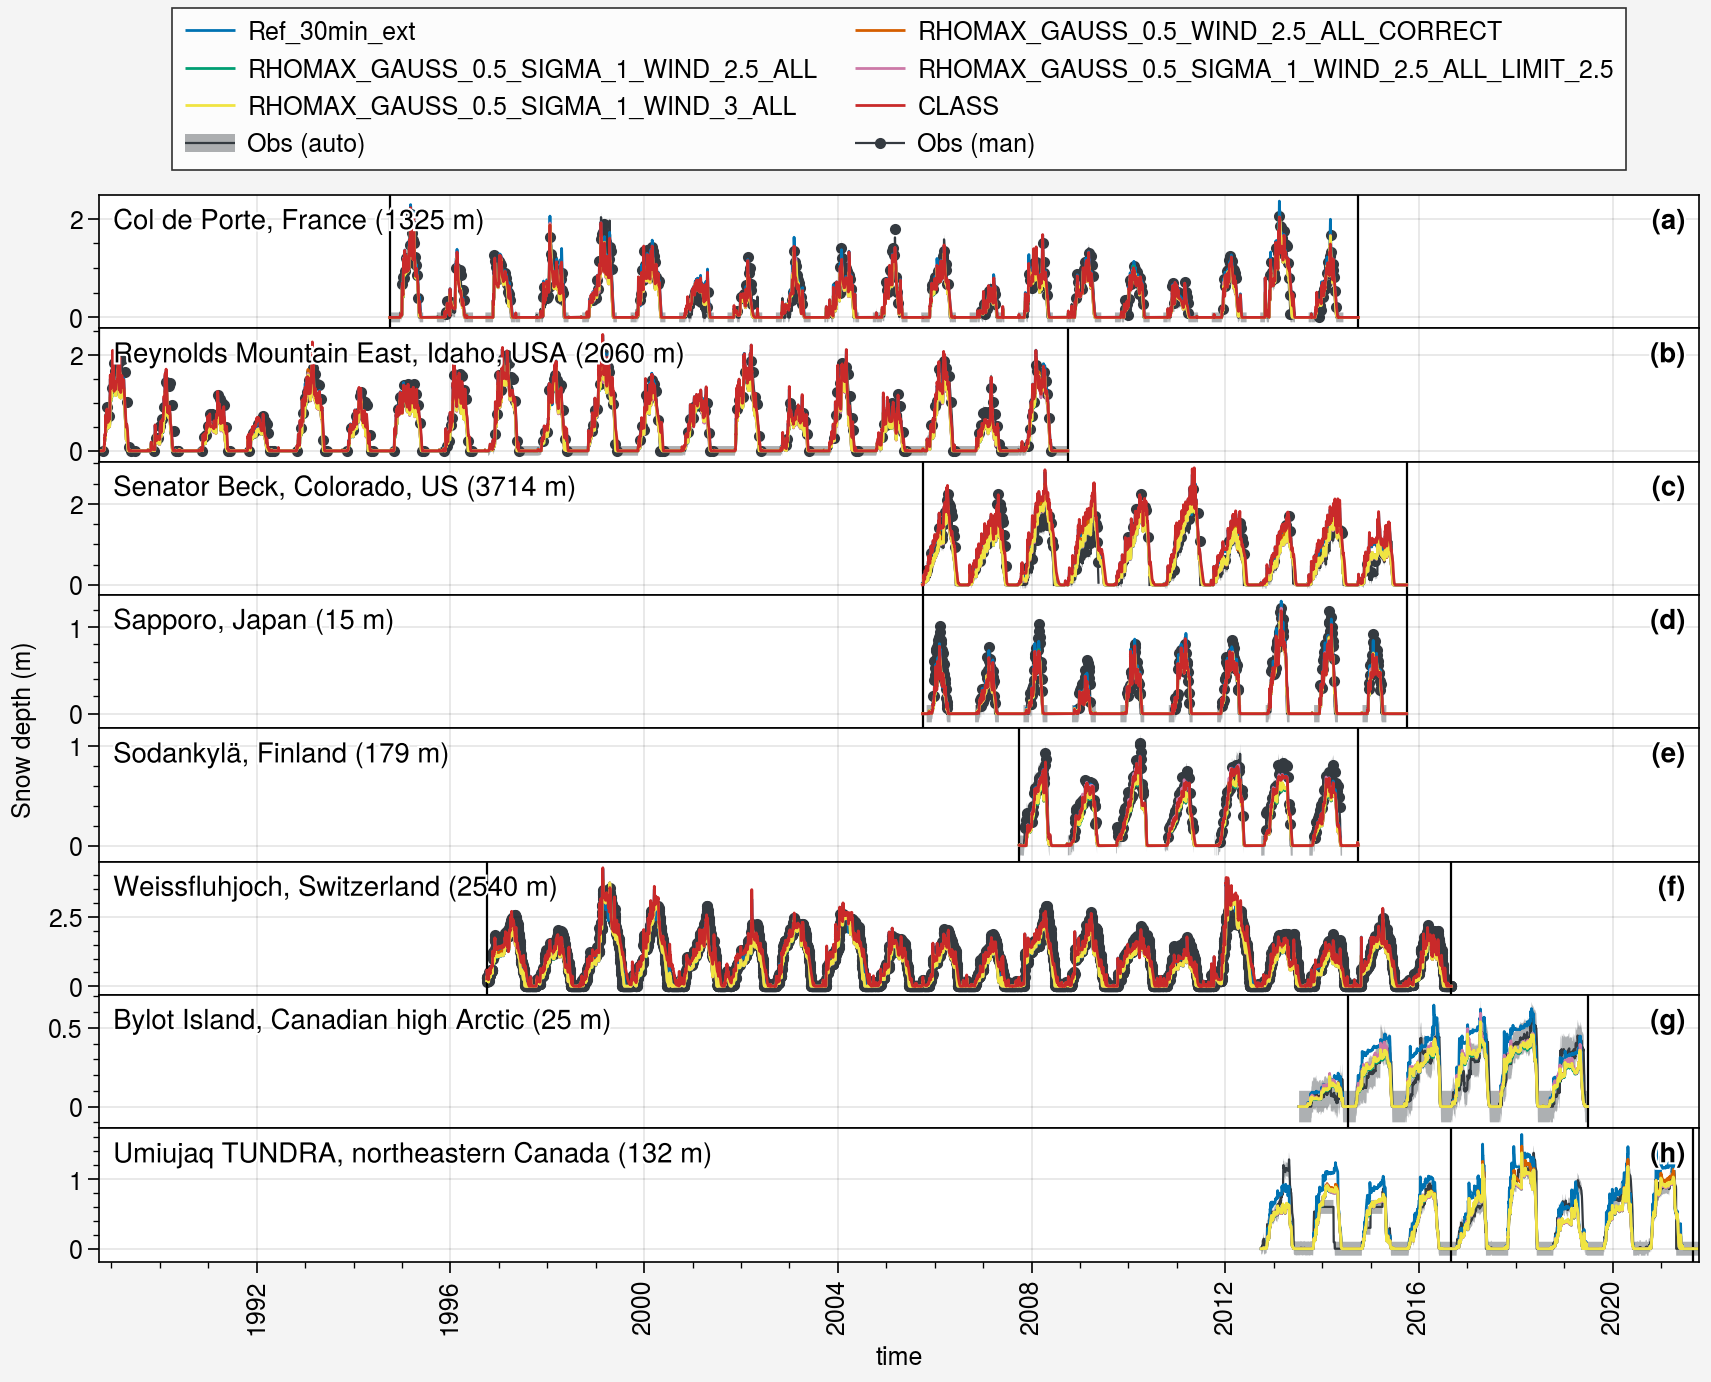

In [10]:
fig, axs = pplt.subplots(nrows=len(SnowMIP_sites+SnowArctic_sites), refaspect=12, refwidth=8, space=0)

color_obs = 'gray8'

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    # Model 
    h_exps = []
    for j, exp in enumerate(exps): 
        h = axs[i].plot(ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop)), label=exp, lw=1)
        h_exps.append(h)

    if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        h_paul = axs[i].plot(ds_d_Paul_list[i].snd.sel(time=slice(site.start, site.stop)), label='CLASS', color='red9', lw=1)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values+0.1, axis=0),
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values-0.1, axis=0),), axis=0)
    h_obs_auto = axs[i].plot(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)), shadedata=shadedata, color=color_obs, 
                zorder=0, lw=0.8, label='Obs (auto)')
    
    if 'snd_man' in list(ds_d_Obs_list[i].keys()):
        h_obs_man = axs[i].plot(ds_d_Obs_list[i].snd_man.sel(time=slice(site.start, site.stop)), marker='.', color=color_obs, 
                    zorder=0, lw=0.8, label='Obs (man)')
    
    axs[i].format(ylabel='Snow depth (m)', ultitle=site.long_name+' ('+site.elevation+')')
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[0], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[-1], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    


# axs[4].legend(ncols=5, loc='ll')
fig.legend(h_exps+h_paul+h_obs_auto+h_obs_man, ncols=2, loc='t')

fig.format(abc='(a)', abcloc='ur')

# fig.suptitle('Col de Porte, France, 1325 m')
# fig.save('img/tn1_sd.jpg')

### Annual cycles

In [11]:
[site.name for site in SnowMIP_sites+SnowArctic_sites]

['cdp', 'rme', 'snb', 'sap', 'sod', 'wfj', 'byl', 'umt']

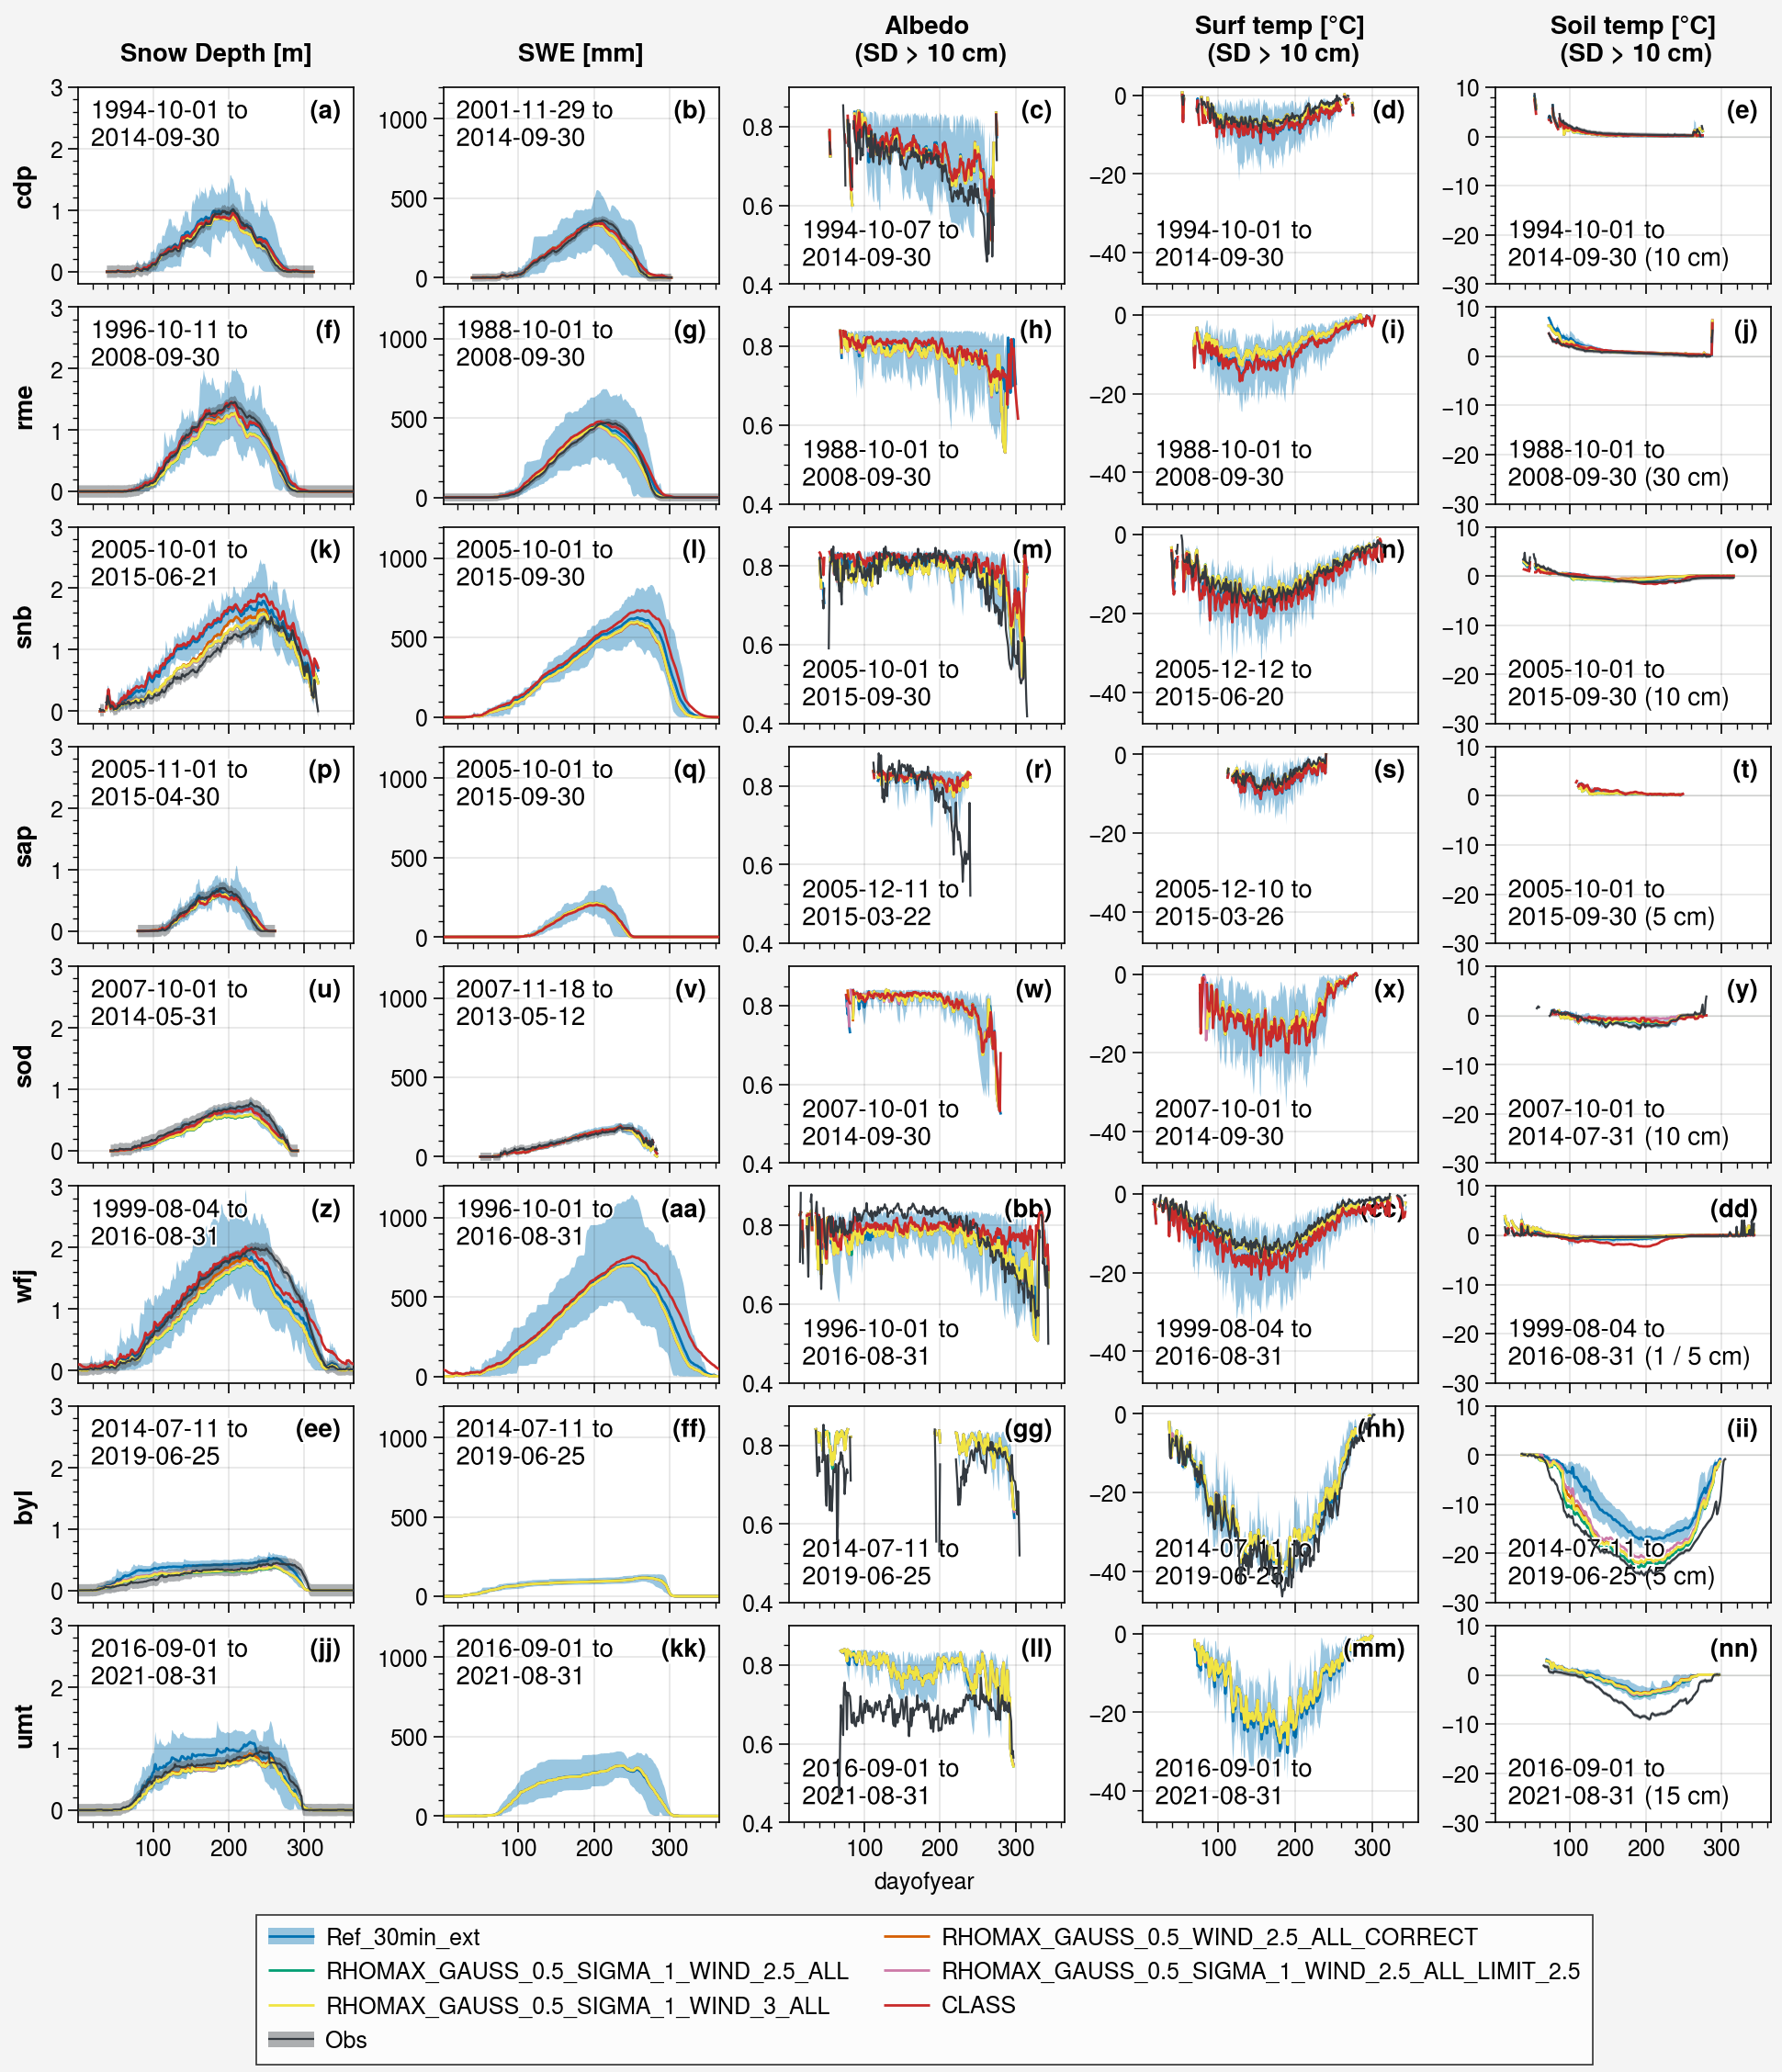

In [12]:
import warnings
warnings.filterwarnings("ignore")

color_obs = 'gray8'

# fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0)
fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0, hspace=1, refaspect=1.4)

# for i, site in enumerate([cdp]):
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):

    doy = 140
    period = site.period_used

    # Snow depth
    ax = axs[i*5+0]
    mask_obs = ~ds_d_Obs_list[i].snd_auto.sel(time=period).isnull()
    
    shadedata = ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
    h1 = ax.plot(ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    h_exps = []
    for j, exp in enumerate(exps[1:]):
        h = ax.plot(ds_d_SnowMIP_list[j+1][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
        h_exps.append(h)

    if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        h_paul = ax.plot(ds_d_Paul_list[i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
    
    obs = ds_d_Obs_list[i].snd_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
    shadedata = np.concatenate((np.expand_dims(obs.values+0.1, axis=0), np.expand_dims(obs.values-0.1, axis=0),), axis=0)
    h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
    ax.format(ylabel='', ylim=(-0.2,3),
              ultitle=str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
              str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[-1].values)[:10])    
    # ax.legend(h1+h_exps+h_paul+h_obs, loc='ul', ncols=1)
    
    # Snow Water Equivalent
    ax = axs[i*5+1]

    if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
        mask_obs = ~ds_d_Obs_list[i].snw_auto.sel(time=period).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        obs = ds_d_Obs_list[i].snw_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        shadedata = np.concatenate((np.expand_dims(obs.values+25, axis=0), np.expand_dims(obs.values-25, axis=0),), axis=0)
        h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
        ax.format(ylabel='', ylim=(-40,1200),
                  ultitle=str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                  str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(-40,1200), ultitle=period.start+' to\n'+ period.stop)


    # Albedo (need to add a condition albsn > 0.4 because a few values are 0 in the model -> bug? (e.g., at Saporo)
    # + low values are observed in the begining of the season (probably due to not full SCF coveraged)
    ax = axs[i*5+2]
    lim_alb = 0.4
    lim_alb_sup = 0.9

    if 'albs' in list(ds_d_Obs_list[i].keys()):
        mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > lim_alb).where(ds_d_Obs_list[i].albs < lim_alb_sup)\
                    .where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                    .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                     .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                     .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
                        .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                        .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                        .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
                            .where(ds_d_Paul_list[i].albsn < lim_alb_sup)\
                            .where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                            .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        if site not in ['umt', 'byl']:
            obs = ds_d_Obs_list[i].albs.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
            h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
            ax.format(ylabel='', ylim=(0.4,0.9),
                      lltitle=str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                    .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                     .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
                        .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                        .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).groupby('time.dayofyear').mean()\
                        .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
                             .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                            .where(ds_d_Paul_list[i].snd > 0.1).groupby('time.dayofyear').mean()\
                            .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(0.4,0.9), lltitle=period.start+' to\n'+ period.stop)
    
    
    # Surface temperature
    # Add condition on ts <= 0 on obs to avoid melting pachy areas to be counted
    ax = axs[i*5+3]

    if 'ts' in list(ds_d_Obs_list[i].keys()) and ds_d_Obs_list[i].ts.notnull().sum() != 0:
        mask_obs = ~ds_d_Obs_list[i].ts.sel(time=period).where(ds_d_Obs_list[i].ts <= 0)\
                    .where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
        obs = ds_d_Obs_list[i].ts.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
        ax.format(ylabel='', ylim=(-48,2),
                  lltitle=str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                  str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(-48,2), lltitle=period.start+' to\n'+ period.stop)

    
    # Soil temperature
    ax = axs[i*5+4]

    if 'tsl' in list(ds_d_Obs_list[i].keys()):
        
        # Get the first soil layer from obs (except for byl)
        if site.name == 'byl':
            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[1].values.item(0) # 0.05 instead of 0.02
        else:
            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0)

        # For wfj (otherwise NaN so take the first model level)
        if obs_sdepth < 0.01: 
            model_sdepth = 0.05
        else:
            model_sdepth = obs_sdepth
        mask_obs = ~ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()

        # Interp model on the first soil layer obs
        if obs_sdepth < 0.01: 
            ds_d_interp = ds_d_SnowMIP_list[0][i]
        else:
            ds_d_interp = ds_d_SnowMIP_list[0][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
        
        shadedata = ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            if obs_sdepth < 0.01: 
                ds_d_interp = ds_d_SnowMIP_list[j+1][i]
            else:
                ds_d_interp = ds_d_SnowMIP_list[j+1][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
            
            h = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            if obs_sdepth < 0.01: 
                ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
            else:
                ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
            h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

        obs = ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(mask_obs).groupby('time.dayofyear').mean()\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        shadedata = np.concatenate((np.expand_dims(obs.values+0.4, axis=0), np.expand_dims(obs.values-0.4, axis=0),), axis=0)
        h_obs = ax.plot(obs, label='Obs', shadedata=shadedata, color=color_obs, lw=0.8, zorder=10)
        ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
        if site.name == 'byl':
            ylim=(-30, 10)
        else:
            ylim=(-30, 10)
            # ylim=(-5, 10)
        if obs_sdepth != model_sdepth: 
            ax.format(ylabel='', ylim=ylim,
                      lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
                         str(round(obs_sdepth*100))+' / '+str(round(model_sdepth*100))+' cm)') 
        else:
            ax.format(ylabel='', ylim=ylim,
                      lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
                         str(round(obs_sdepth*100))+' cm)')

    else:
        model_sdepth = 0.05 # first level
        
        shadedata = ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):            
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
            ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
            h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1)\
                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                             .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

        ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
        ax.format(ylabel='', ylim=ylim, lltitle=period.start+' to\n'+ period.stop+' ('+\
                     str(round(model_sdepth*100))+' cm)')
    
    
# for ax in axs:
#     ax.format(xlim=(40,350))
    
fig.format(abc='(a)', abcloc='ur', 
           collabels=['Snow Depth [m]', 'SWE [mm]', 'Albedo\n (SD > 10 cm)', 'Surf temp [°C]\n (SD > 10 cm)', 
                      'Soil temp [°C]\n (SD > 10 cm)'],
           rowlabels=[site.name for site in SnowMIP_sites+SnowArctic_sites])
fig.legend(h1+h_exps+h_paul+h_obs, loc='b', ncols=2)

# fig.save('img/tn1_ac.jpg')


## Metrics

## Time series

In [13]:
def mb(simu, obs):
    return (simu-obs).mean().values.item(0)

def rmb(simu, obs):
    return ((simu-obs).mean()/np.abs(obs.mean())).values.item(0)*100
    
def mab(simu, obs):
    return (np.abs(simu-obs)).mean().values.item(0)

def rmab(simu, obs):
    return ((np.abs(simu-obs)).mean()/np.abs(obs.mean())).values.item(0)*100
    
def rmse(simu, obs):
    return np.sqrt(((simu-obs)**2).mean()).values.item(0)

def rrmse(simu, obs):
    return (np.sqrt(((simu-obs)**2).mean())/np.abs(obs.mean())).values.item(0)*100
    
def corr(simu, obs):
    return xr.corr(simu, obs).values.item(0)

In [14]:
def mb_a(simu, obs):
    return (simu-obs).mean()

def rmb_a(simu, obs):
    return ((simu-obs).mean()/np.abs(obs.mean()))*100
    
def mab_a(simu, obs):
    return (np.abs(simu-obs)).mean()

def rmab_a(simu, obs):
    return ((np.abs(simu-obs)).mean()/np.abs(obs.mean()))*100
    
def rmse_a(simu, obs):
    return np.sqrt(((simu-obs)**2).mean())

def rrmse_a(simu, obs):
    return (np.sqrt(((simu-obs)**2).mean())/np.abs(obs.mean()))*100
    
def corr_a(simu, obs):
    r, _ = stats.pearsonr(simu, obs)
    return r

In [15]:
# Can be negative if rmse > std
def calculate_score(std_deviation, rmse):
    return (std_deviation - rmse) / std_deviation

In [16]:
['Obs'] + [site.name for site in SnowMIP_sites]

['Obs', 'cdp', 'rme', 'snb', 'sap', 'sod', 'wfj']

In [17]:
exps

['Ref_30min_ext',
 'RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT',
 'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL',
 'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5',
 'RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL']

In [18]:
df_metrics_list = []
column_indexes = ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']

for site in SnowMIP_sites+SnowArctic_sites:
    row_indexes = [['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD'], 
                   ['Obs', 'CLASS']+exps]
    rows = pd.MultiIndex.from_product(row_indexes)
    
    df_metrics = pd.DataFrame(index=rows, columns=column_indexes)
    df_metrics_list.append(df_metrics)
    
df_metrics_list[0]

mb  rmb  nmb  mab  \
snd_auto Obs                                              NaN  NaN  NaN  NaN   
         CLASS                                            NaN  NaN  NaN  NaN   
         Ref_30min_ext                                    NaN  NaN  NaN  NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            NaN  NaN  NaN  NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            NaN  NaN  NaN  NaN   
...                                                       ...  ...  ...  ...   
SCD      Ref_30min_ext                                    NaN  NaN  NaN  NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            NaN  NaN  NaN  NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            NaN  NaN  NaN  NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5  NaN  NaN  NaN  NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL              NaN  NaN  NaN  NaN   

                                                         rmab rmse rrmse  \
snd_auto Obs                                              NaN  NaN   NaN   
         CLASS                                            NaN  NaN   NaN   
         Ref_30min_ext                                    NaN  NaN   NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            NaN  NaN   NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            NaN  NaN   NaN   
...                                                       ...  ...   ...   
SCD      Ref_30min_ext                                    NaN  NaN   NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            NaN  NaN   NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            NaN  NaN   NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5  NaN  NaN   NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL              NaN  NaN   NaN   

                                                         nrmse    r stdd score  
snd_auto Obs                                               NaN  NaN  NaN   NaN  
         CLASS                                             NaN  NaN  NaN   NaN  
         Ref_30min_ext                                     NaN  NaN  NaN   NaN  
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT             NaN  NaN  NaN   NaN  
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL             NaN  NaN  NaN   NaN  
...                                                        ...  ...  ...   ...  
SCD      Ref_30min_ext                                     NaN  NaN  NaN   NaN  
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT             NaN  NaN  NaN   NaN  
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL             NaN  NaN  NaN   NaN  
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5   NaN  NaN  NaN   NaN  
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL               NaN  NaN  NaN   NaN  

[63 rows x 11 columns]

In [19]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    period = site.period_used
    for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl']:

        if site.name in ['byl', 'umt', 'umf']:
            arr1 = ['Obs']+exps
            arr2 = [ds_d_Obs_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
        else:
            arr1 = ['Obs', 'CLASS']+exps
            arr2 = [ds_d_Obs_list[i], ds_d_Paul_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
            
        for exp, ds_simu in zip(arr1, arr2):

            # We are going to make a common mask based on snd_auto so the comparison will be on the same period (auto/man)
            mask_obs_snd = ~ds_d_Obs_list[i].snd_auto.where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
            if exp == 'Obs':
                if var == 'snd_auto':
                    obs = ds_d_Obs_list[i].snd_auto.where(mask_obs_snd).sel(time=period)
                    simu = obs
                elif var == 'snd_man':
                    if 'snd_man' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].snd_man.where(ds_d_Obs_list[i].snd_man > 0.1).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].snd_man.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'snw_auto':
                    if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
                        obs = ds_d_Obs_list[i].snw_auto.where(mask_obs_snd).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'snw_man':
                    if 'snw_man' in list(ds_d_Obs_list[i].keys()):
                        obs = ds_d_Obs_list[i].snw_man.where(mask_obs_snd).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'albs':
                    if 'albs' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > 0.4)\
                                    .where(ds_d_Obs_list[i].albs < 0.9).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].albs.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'ts':
                    if 'ts' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].ts.where(ds_d_Obs_list[i].ts <= 0).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].ts.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'tsl':
                    if 'tsl' in list(ds_d_Obs_list[i].keys()):
                        # Get the first soil layer from obs
                        if site.name == 'byl':
                            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[1].values.item(0)
                        else:
                            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0) 
                        obs = ds_d_Obs_list[i].tsl.where(mask_obs_snd).sel(time=period, sdepth=obs_sdepth)
                        simu = obs
                    else:
                        pass
                else:
                    raise ValueError(var+" is not supported.")
                    
            # Model
            else:
                mask_simu_snd = ~ds_simu.snd.where(ds_simu.snd > 0.1).sel(time=period).isnull()
                if var in ['snd_auto', 'snd_man']:
                    simu = ds_simu.snd.where(obs.notnull()).where(mask_simu_snd).sel(time=period)
                elif var in ['snw_auto', 'snw_man']:
                    simu = ds_simu.snw.where(obs.notnull()).where(mask_simu_snd).sel(time=period)
                elif var == 'albs':
                    simu = ds_simu['albsn'].where(ds_simu.albsn > 0.4).where(ds_simu.albsn < 0.9).where(obs.notnull())\
                            .where(mask_simu_snd).sel(time=period)
                elif var == 'ts':
                    simu = ds_simu[var].where(obs.notnull()).where(mask_simu_snd).sel(time=period)-273.15
                elif var == 'tsl':
                    if 'tsl' in list(ds_d_Obs_list[i].keys()):
                        # Interp model on the first soil layer obs
                        if obs_sdepth < 0.01: 
                            ds_d_interp = ds_simu[var]
                            model_sdepth = 0.05
                        else:
                            ds_d_interp = ds_simu[var].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
                            model_sdepth = obs_sdepth
                        simu = ds_d_interp.where(obs.notnull()).where(mask_simu_snd).sel(time=period, layer=model_sdepth)-273.15
                    else:
                        pass
                else:
                    raise ValueError(var+" is not supported.")

            if var in list(ds_d_Obs_list[i].keys()):
                # Remove albedo for Arctic sites because suspect wrong values
                if not (site.name in ['byl', 'umt', 'umf'] and var == 'albs'):
                    df_metrics_list[i].loc[(var, exp), 'mb'] = mb(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rmb'] = rmb(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'nmb'] = mb(simu, obs)/obs.std().values.item(0)
                    df_metrics_list[i].loc[(var, exp), 'mab'] = mab(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rmab'] = rmab(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rmse'] = rmse(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rrmse'] = rrmse(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'nrmse'] = rmse(simu, obs)/obs.std().values.item(0)
                    df_metrics_list[i].loc[(var, exp), 'r'] = corr(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'stdd'] = simu.std().values.item(0)
                    df_metrics_list[i].loc[(var, exp), 'score'] = calculate_score(obs.std().values.item(0), rmse(simu, obs))

            
df_metrics_list[0]

mb       rmb  \
snd_auto Obs                                                   0.0       0.0   
         CLASS                                            0.009846  1.424197   
         Ref_30min_ext                                    0.056881  8.227255   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            -0.04475 -6.472603   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL           -0.048795 -7.057758   
...                                                            ...       ...   
SCD      Ref_30min_ext                                         NaN       NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                 NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                 NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5       NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                   NaN       NaN   

                                                               nmb       mab  \
snd_auto Obs                                                   0.0       0.0   
         CLASS                                            0.025019  0.138836   
         Ref_30min_ext                                     0.14453  0.141662   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT           -0.113705  0.131078   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL           -0.123985  0.132879   
...                                                            ...       ...   
SCD      Ref_30min_ext                                         NaN       NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                 NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                 NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5       NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                   NaN       NaN   

                                                               rmab      rmse  \
snd_auto Obs                                                    0.0       0.0   
         CLASS                                             20.08126   0.17702   
         Ref_30min_ext                                    20.489998  0.183213   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            18.959206  0.172784   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            19.219574  0.173536   
...                                                             ...       ...   
SCD      Ref_30min_ext                                          NaN       NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5        NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                    NaN       NaN   

                                                              rrmse     nrmse  \
snd_auto Obs                                                    0.0       0.0   
         CLASS                                            25.604197  0.449794   
         Ref_30min_ext                                    26.500015  0.465531   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            24.991508  0.439031   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            25.100287  0.440942   
...                                                             ...       ...   
SCD      Ref_30min_ext                                          NaN       NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5        NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                    NaN       NaN   

                                                                 r      stdd  \
snd_auto Obs                                              0.999998  0.393558   
         CLASS                      

In [20]:
df_metrics_list[-2]

mb        rmb  \
snd_auto Obs                                                   0.0        0.0   
         CLASS                                                 NaN        NaN   
         Ref_30min_ext                                    0.091729  29.968866   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT              -0.018  -5.880791   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL           -0.024865  -8.123545   
...                                                            ...        ...   
SCD      Ref_30min_ext                                         NaN        NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                 NaN        NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                 NaN        NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5       NaN        NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                   NaN        NaN   

                                                               nmb       mab  \
snd_auto Obs                                                   0.0       0.0   
         CLASS                                                 NaN       NaN   
         Ref_30min_ext                                    0.807494  0.117075   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT           -0.158455  0.077848   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL           -0.218884  0.077811   
...                                                            ...       ...   
SCD      Ref_30min_ext                                         NaN       NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                 NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                 NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5       NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                   NaN       NaN   

                                                               rmab      rmse  \
snd_auto Obs                                                    0.0       0.0   
         CLASS                                                  NaN       NaN   
         Ref_30min_ext                                    38.249907  0.138395   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            25.433761  0.095558   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            25.421715  0.096602   
...                                                             ...       ...   
SCD      Ref_30min_ext                                          NaN       NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5        NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                    NaN       NaN   

                                                              rrmse     nrmse  \
snd_auto Obs                                                    0.0       0.0   
         CLASS                                                  NaN       NaN   
         Ref_30min_ext                                    45.215247  1.218299   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT             31.21983  0.841201   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            31.561021  0.850394   
...                                                             ...       ...   
SCD      Ref_30min_ext                                          NaN       NaN   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                  NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5        NaN       NaN   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                    NaN       NaN   

                                                                 r      stdd  \
snd_auto Obs                                                   1.0  0.113597   
         CLASS          

In [21]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    period = site.period_used
    for var in ['SCD']:
        
        if site.name in ['byl', 'umt', 'umf']:
            arr1 = ['Obs']+exps
            arr2 = [ds_d_Obs_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
        else:
            arr1 = ['Obs', 'CLASS']+exps
            arr2 = [ds_d_Obs_list[i], ds_d_Paul_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
            
        for exp, ds_simu in zip(arr1, arr2):

            mask = ds_d_Obs_list[i].snd_auto > 0.1
            obs = ds_d_Obs_list[i].snd_auto.where(mask).sel(time=period).notnull()\
                    .resample(time='AS-'+calendar.month_abbr[int(period.start[5:7])]).sum()
            obs = obs.where(obs > 0)
            if exp == 'Obs':
                simu = obs
            else:
                simu = ds_simu.snd.where(ds_simu.snd > 0.1).sel(time=period).notnull()\
                        .resample(time='AS-'+calendar.month_abbr[int(period.start[5:7])]).sum().where(obs.notnull())
    
            df_metrics_list[i].loc[(var, exp), 'mb'] = mb(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmb'] = rmb(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'nmb'] = mb(simu, obs)/obs.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'mab'] = mab(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmab'] = rmab(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmse'] = rmse(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rrmse'] = rrmse(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'nrmse'] = rmse(simu, obs)/obs.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'r'] = corr(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'stdd'] = simu.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'score'] = calculate_score(obs.std().values.item(0), rmse(simu, obs))
            
df_metrics_list[0]

mb        rmb  \
snd_auto Obs                                                   0.0        0.0   
         CLASS                                            0.009846   1.424197   
         Ref_30min_ext                                    0.056881   8.227255   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            -0.04475  -6.472603   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL           -0.048795  -7.057758   
...                                                            ...        ...   
SCD      Ref_30min_ext                                       17.05  12.301587   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT                10.2   7.359307   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL                10.4   7.503608   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5     10.15   7.323232   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                 10.15   7.323232   

                                                               nmb       mab  \
snd_auto Obs                                                   0.0       0.0   
         CLASS                                            0.025019  0.138836   
         Ref_30min_ext                                     0.14453  0.141662   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT           -0.113705  0.131078   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL           -0.123985  0.132879   
...                                                            ...       ...   
SCD      Ref_30min_ext                                    0.744591     18.05   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            0.445445      13.0   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            0.454179      13.1   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5  0.443261     12.95   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL              0.443261     12.95   

                                                               rmab  \
snd_auto Obs                                                    0.0   
         CLASS                                             20.08126   
         Ref_30min_ext                                    20.489998   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            18.959206   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL            19.219574   
...                                                             ...   
SCD      Ref_30min_ext                                    13.023088   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT             9.379509   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL             9.451659   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5   9.343434   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL               9.343434   

                                                               rmse  \
snd_auto Obs                                                    0.0   
         CLASS                                              0.17702   
         Ref_30min_ext                                     0.183213   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT             0.172784   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL             0.173536   
...                                                             ...   
SCD      Ref_30min_ext                                    23.107358   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            18.387496   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL             18.59032   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5  18.339847   
         RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL              18.386136   

                                                              rrmse     nrmse  \
snd_auto Obs                                                    0.0       0.0   
         CLASS                                            25.604197  0.449794   
         Ref_30min_ext                                    26.500015  0.465531   
         RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT            24.991508  0.439031   
         RHOMAX_GAU

In [22]:
df_metrics_list[-2].loc[('albs')]

,mb,rmb,nmb,mab,rmab,rmse,rrmse,nrmse,r,stdd,score
Obs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ref_30min_ext,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Menard plot
https://journals.ametsoc.org/view/journals/bams/102/1/BAMS-D-19-0329.1.xml

In [23]:
# For calculating the mean of each site
df_gather = df_metrics_list[0].copy()
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD']:
    for metric in ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']:
        for exp in ['Obs', 'CLASS']+exps:
            array_gather = np.array([df_metrics_list[i].loc[(var, exp), metric] for i, site in enumerate(SnowMIP_sites)])
            df_gather.loc[(var, exp), metric] = array_gather

df_gather_Arctic = df_metrics_list[0].copy()
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD']:
    for metric in ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']:
        for exp in ['Obs', 'CLASS']+exps:
            if exp == 'CLASS':
                array_gather = np.nan
            else:
                array_gather = np.array([df_metrics_list[i].loc[(var, exp), metric] for i, site in enumerate(SnowMIP_sites+SnowArctic_sites)])
            df_gather_Arctic.loc[(var, exp), metric] = array_gather

In [24]:
df_gather.loc[('albs')]

,mb,rmb,nmb,mab,rmab,rmse,rrmse,nrmse,r,stdd,score
Obs,"[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, nan, 0.0]","[0.9999996763203693, nan, 1.000000962907109, 0...","[0.0953909158706665, nan, 0.0912841334939003, ...","[1.0, nan, 1.0, 1.0, nan, 1.0]"
CLASS,"[0.04024505687062008, nan, 0.03238778940883403...","[5.827226802366112, nan, 4.165086209787148, 3....","[0.42189611561320345, nan, 0.35480195921450275...","[0.06631090721626443, nan, 0.05300730073941628...","[9.60139519896956, nan, 6.816765866322551, 7.4...","[0.08457069293180147, nan, 0.07518190482605833...","[12.245295369594412, nan, 9.668431243138013, 1...","[0.8865696713350003, nan, 0.823603204067025, 0...","[0.680454210501211, nan, 0.698551630410033, 0....","[0.09090764653009185, nan, 0.04525343671871823...","[0.11343032866499964, nan, 0.17639679593297491..."
Ref_30min_ext,"[0.039085534439675496, nan, 0.0180317781875001...","[5.659335371394434, nan, 2.318895856665419, 3....","[0.40974063497480917, nan, 0.19753463715252337...","[0.06338640306968973, nan, 0.0465590067386604,...","[9.177945705499175, nan, 5.9875119743642475, 7...","[0.08160967003419821, nan, 0.06666468137281682...","[11.816558194571813, nan, 8.573111970094457, 1...","[0.8555287397056417, nan, 0.730298670987236, 0...","[0.7030722177420224, nan, 0.7211367847993436, ...","[0.09094644581192593, nan, 0.05491565980273587...","[0.1444712602943583, nan, 0.269701329012764, 0..."
RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT,"[0.03177114150395923, nan, 0.00570404067684261...","[4.600258061724665, nan, 0.7335425355304429, 3...","[0.33306254808408986, nan, 0.06248666069907722...","[0.06091391118643435, nan, 0.04451033424473975...","[8.819944696404901, nan, 5.724051648465261, 6....","[0.07859799302682592, nan, 0.06334281733410972...","[11.380486628469958, nan, 8.145918563228815, 1...","[0.82395679200094, nan, 0.6939082939133376, 0....","[0.7034700537694779, nan, 0.7220043041889395, ...","[0.09322744696734545, nan, 0.05847951021889588...","[0.17604320799906006, nan, 0.3060917060866623,..."
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL,"[0.03256882356893518, nan, 0.00575656249111570...","[4.715757322260881, nan, 0.7402968675899859, 3...","[0.3414247915712733, nan, 0.06306202700056697,...","[0.06104147865757587, nan, 0.044482738505861, ...","[8.838415650225036, nan, 5.7205028223937475, 6...","[0.07875374198565324, nan, 0.06321410926243938...","[11.403038081440615, nan, 8.129366639674062, 1...","[0.8255895361402088, nan, 0.6924983219199141, ...","[0.7057174627084166, nan, 0.7253245634703209, ...","[0.09329016765671748, nan, 0.05835807551767748...","[0.1744104638597912, nan, 0.30750167808008594,..."
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5,"[0.03137266634125296, nan, 0.00583939301762554...","[4.542561407060615, nan, 0.7509489154763244, 3...","[0.32888526181873373, nan, 0.06396941937358408...","[0.06138002264908209, nan, 0.04442004809446702...","[8.887434654656492, nan, 5.712440803566624, 6....","[0.07903062827422379, nan, 0.06313101382021877...","[11.443129444888129, nan, 8.118680523492424, 1...","[0.8284921845322838, nan, 0.6915880274466016, ...","[0.6994323997000977, nan, 0.7253635985095479, ...","[0.0936707241638851, nan, 0.05799561708006058,...","[0.17150781546771623, nan, 0.30841197255339836..."
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL,"[0.03205106088047944, nan, 0.00572722067544709...","[4.640788596905768, nan, 0.7365234951541972, 3...","[0.33599699287859974, nan, 0.06274059309364857...","[0.060892177085530595, nan, 0.0444723583768359...","[8.816797737618911, nan, 5.719167932515582, 6....","[0.07843473188374343, nan, 0.06322905360953872...","[11.356847459271771, nan, 8.131288490320674, 1...","[0.8222452962930694, nan, 0.6926620343475545, ...","[0.7064479550124547, nan, 0.7249797471769558, ...","[0.09341557490008705, nan, 0.058454

In [25]:
df_gather_Arctic.loc[('albs')]

,mb,rmb,nmb,mab,rmab,rmse,rrmse,nrmse,r,stdd,score
Obs,"[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan]","[0.9999996763203693, nan, 1.000000962907109, 0...","[0.0953909158706665, nan, 0.0912841334939003, ...","[1.0, nan, 1.0, 1.0, nan, 1.0, nan, nan]"
CLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ref_30min_ext,"[0.039085534439675496, nan, 0.0180317781875001...","[5.659335371394434, nan, 2.318895856665419, 3....","[0.40974063497480917, nan, 0.19753463715252337...","[0.06338640306968973, nan, 0.0465590067386604,...","[9.177945705499175, nan, 5.9875119743642475, 7...","[0.08160967003419821, nan, 0.06666468137281682...","[11.816558194571813, nan, 8.573111970094457, 1...","[0.8555287397056417, nan, 0.730298670987236, 0...","[0.7030722177420224, nan, 0.7211367847993436, ...","[0.09094644581192593, nan, 0.05491565980273587...","[0.1444712602943583, nan, 0.269701329012764, 0..."
RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT,"[0.03177114150395923, nan, 0.00570404067684261...","[4.600258061724665, nan, 0.7335425355304429, 3...","[0.33306254808408986, nan, 0.06248666069907722...","[0.06091391118643435, nan, 0.04451033424473975...","[8.819944696404901, nan, 5.724051648465261, 6....","[0.07859799302682592, nan, 0.06334281733410972...","[11.380486628469958, nan, 8.145918563228815, 1...","[0.82395679200094, nan, 0.6939082939133376, 0....","[0.7034700537694779, nan, 0.7220043041889395, ...","[0.09322744696734545, nan, 0.05847951021889588...","[0.17604320799906006, nan, 0.3060917060866623,..."
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL,"[0.03256882356893518, nan, 0.00575656249111570...","[4.715757322260881, nan, 0.7402968675899859, 3...","[0.3414247915712733, nan, 0.06306202700056697,...","[0.06104147865757587, nan, 0.044482738505861, ...","[8.838415650225036, nan, 5.7205028223937475, 6...","[0.07875374198565324, nan, 0.06321410926243938...","[11.403038081440615, nan, 8.129366639674062, 1...","[0.8255895361402088, nan, 0.6924983219199141, ...","[0.7057174627084166, nan, 0.7253245634703209, ...","[0.09329016765671748, nan, 0.05835807551767748...","[0.1744104638597912, nan, 0.30750167808008594,..."
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5,"[0.03137266634125296, nan, 0.00583939301762554...","[4.542561407060615, nan, 0.7509489154763244, 3...","[0.32888526181873373, nan, 0.06396941937358408...","[0.06138002264908209, nan, 0.04442004809446702...","[8.887434654656492, nan, 5.712440803566624, 6....","[0.07903062827422379, nan, 0.06313101382021877...","[11.443129444888129, nan, 8.118680523492424, 1...","[0.8284921845322838, nan, 0.6915880274466016, ...","[0.6994323997000977, nan, 0.7253635985095479, ...","[0.0936707241638851, nan, 0.05799561708006058,...","[0.17150781546771623, nan, 0.30841197255339836..."
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL,"[0.03205106088047944, nan, 0.00572722067544709...","[4.640788596905768, nan, 0.7365234951541972, 3...","[0.33599699287859974, nan, 0.06274059309364857...","[0.060892177085530595, nan, 0.0444723583768359...","[8.816797737618911, nan, 5.719167932515582, 6....","[0.07843473188374343, nan, 0.06322905360953872...","[11.356847459271771, nan, 8.131288490320674, 1...","[0.8222452962930694, nan, 0.6926620343475545, ...","[0.7064479550124547, nan, 0.7249797471769558, ...","[0.09341557490008705, nan, 0.05845429635837547...","[0.17775470370693064, nan, 0.30733796565244553..."


### RMSE

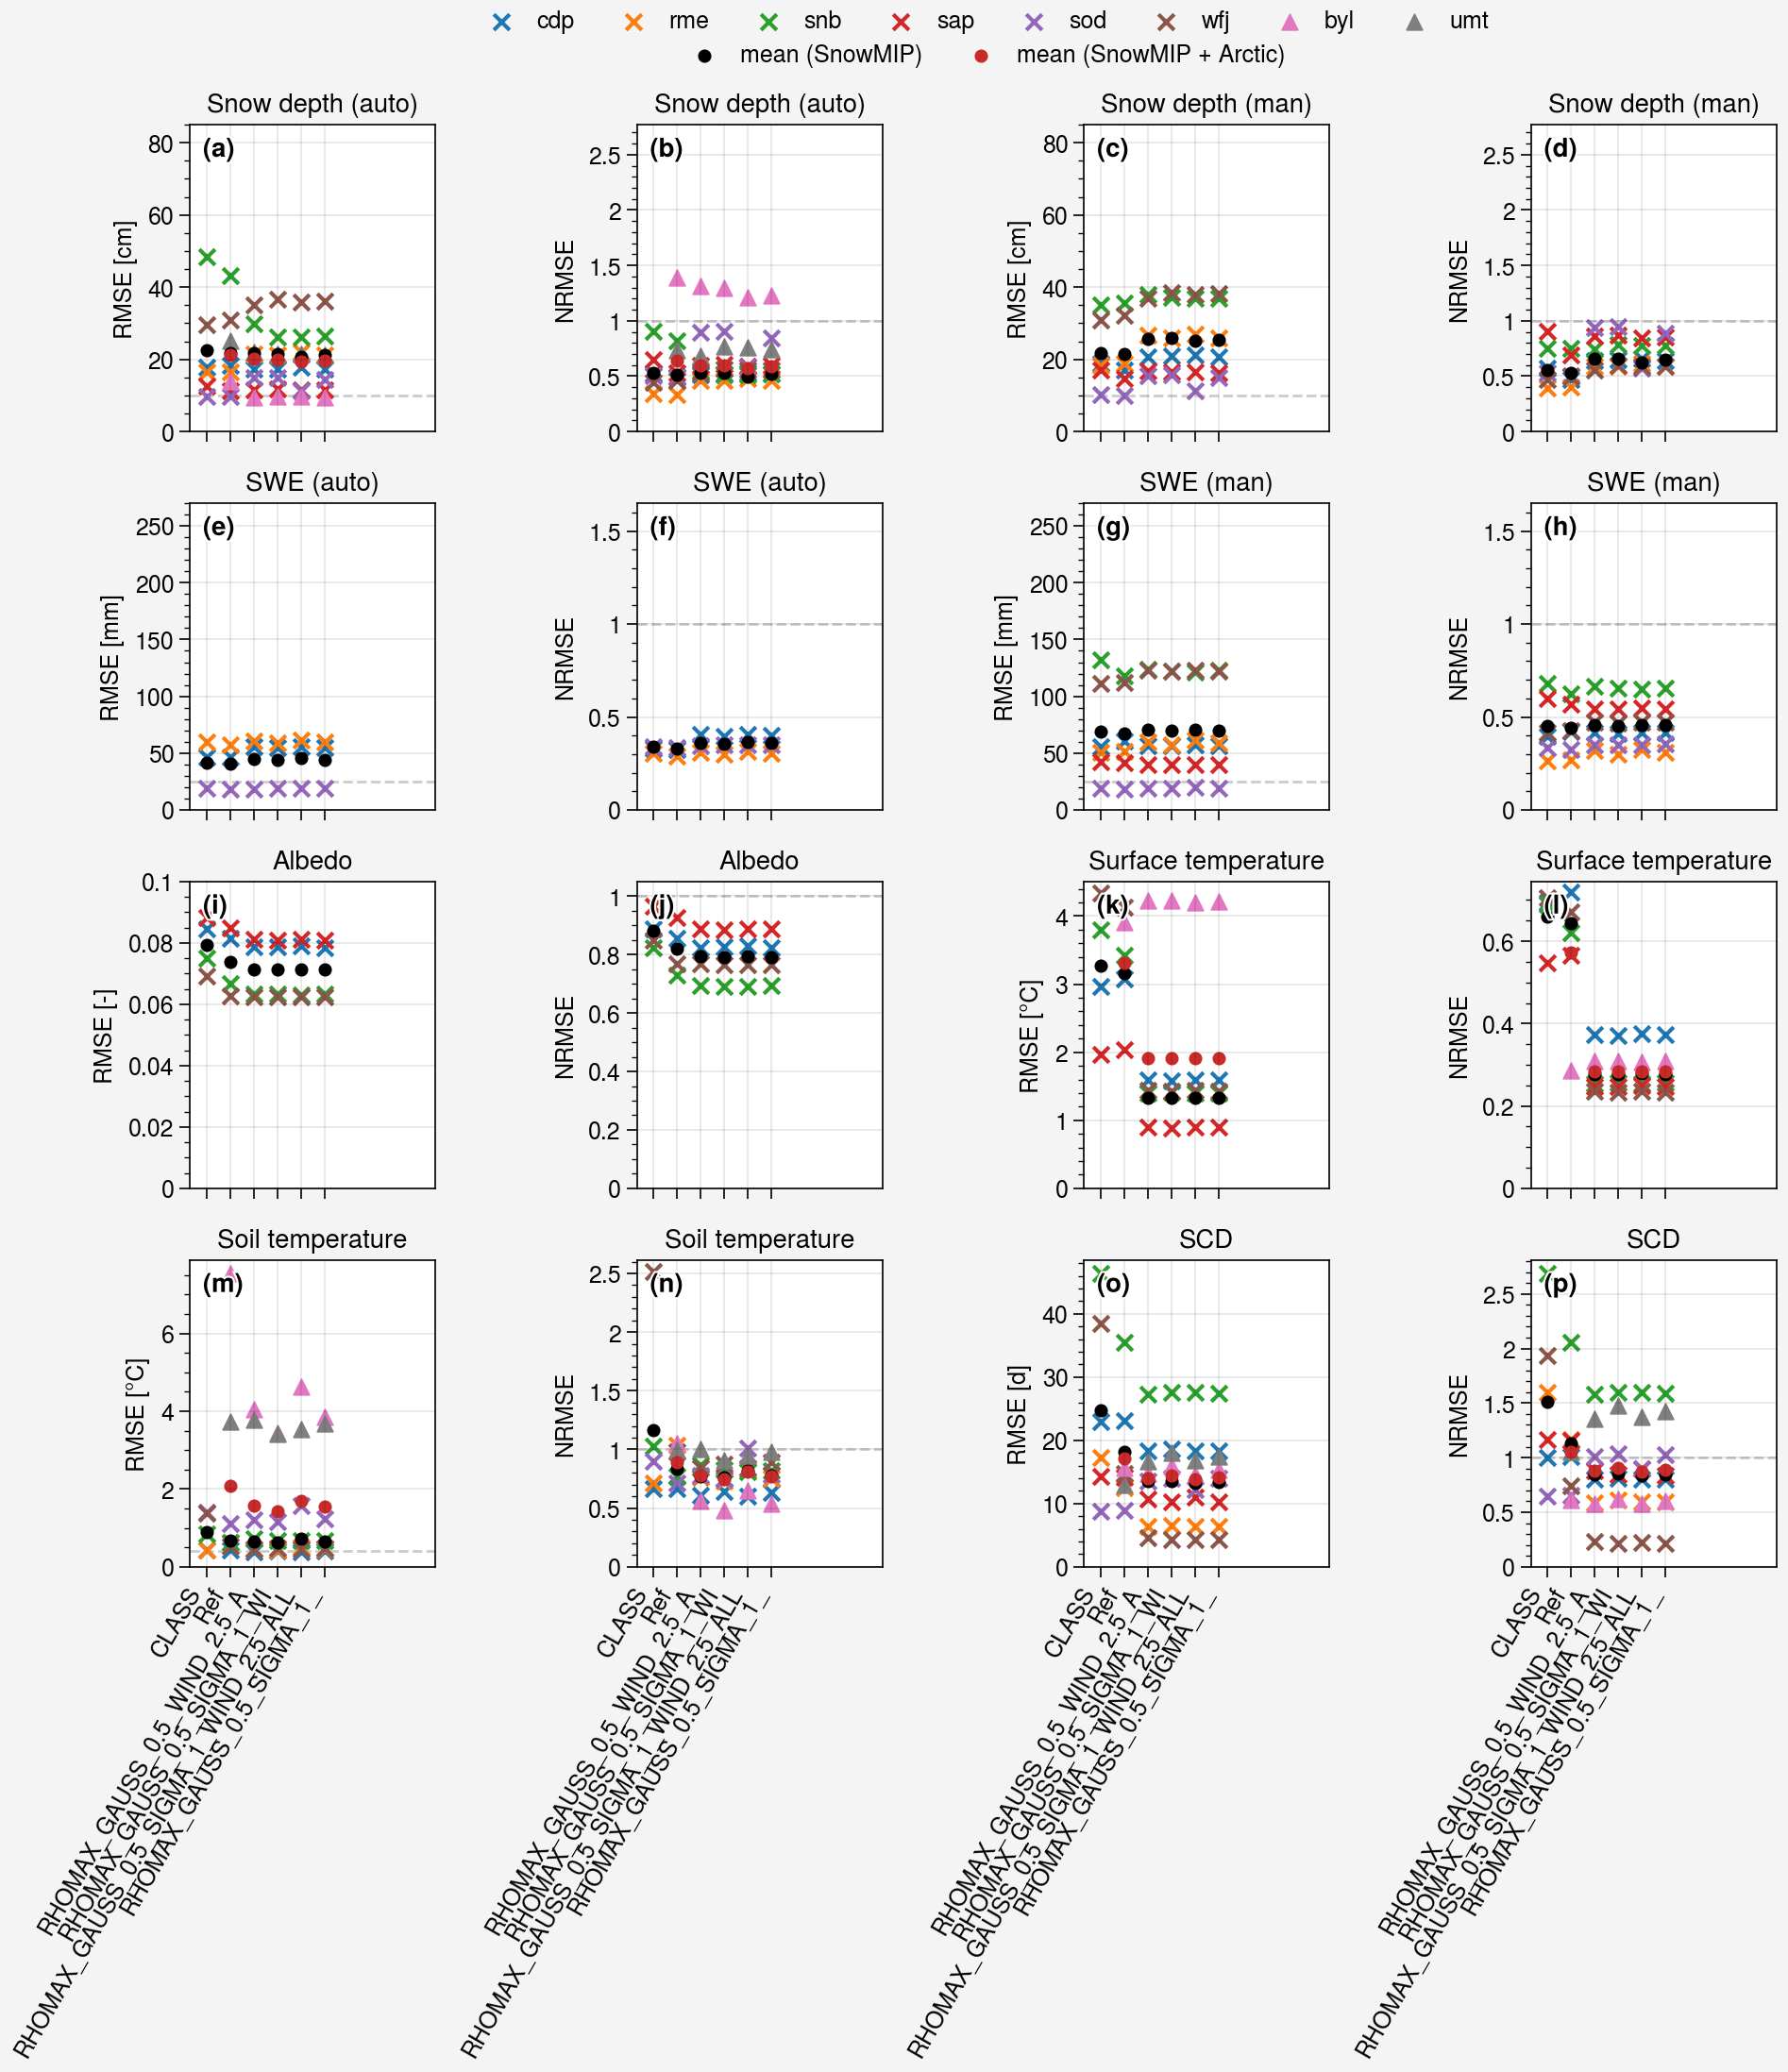

In [26]:
fig, axs = pplt.subplots(ncols=4, nrows=4, sharey=0, refaspect=0.8, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation = 60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean (SnowMIP)'; color_mean='k'; marker_mean_size=80
marker_mean_arc='.'; label_mean_arc='mean (SnowMIP + Arctic)'; color_mean_arc='red9'; marker_mean_arc_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].rmse[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].rmse[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].rmse[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='RMSE [cm]', xrotation=xrotation, ylim=(0, 85))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].rmse[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].rmse[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].rmse[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='RMSE [cm]', xrotation=xrotation, ylim=(0, 85))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].rmse[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nrmse[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nrmse[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
# axs[1].format(title='Snow depth (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.58))
axs[1].format(title='Snow depth (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 2.77))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].rmse[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nrmse[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 2.77))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='RMSE [mm]', xrotation=xrotation, ylim=(0, 270))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].rmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='RMSE [mm]', xrotation=xrotation, ylim=(0, 270))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].rmse[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nrmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.65))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].rmse[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nrmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.65))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[8].scatter(df_gather_Arctic.loc[('albs')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='RMSE [-]', xrotation=xrotation, ylim=(0, 0.1))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('albs')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('albs')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[9].scatter(df_gather_Arctic.loc[('albs')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Albedo', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.05))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('ts')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('ts')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('ts')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Surface temperature', ylabel='RMSE [°C]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('ts')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('ts')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('ts')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='Surface temperature', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[12].scatter(df_metrics_list[i].loc[('tsl')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[12].scatter(df_gather.loc[('tsl')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[12].scatter(df_gather_Arctic.loc[('tsl')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[12].format(title='Soil temperature', ylabel='RMSE [°C]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[13].scatter(df_metrics_list[i].loc[('tsl')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[13].scatter(df_gather.loc[('tsl')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[13].scatter(df_gather_Arctic.loc[('tsl')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[13].format(title='Soil temperature', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[14].scatter(df_metrics_list[i].loc[('SCD')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[14].scatter(df_gather.loc[('SCD')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[14].scatter(df_gather_Arctic.loc[('SCD')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[14].format(title='SCD', ylabel='RMSE [d]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[15].scatter(df_metrics_list[i].loc[('SCD')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[15].scatter(df_gather.loc[('SCD')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[15].scatter(df_gather_Arctic.loc[('SCD')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[15].format(title='SCD', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

x_min = -0.7
# x_max = 2.7
x_max = 9.7
for i, ax in enumerate(axs):
    ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    if (i % 2) != 0:
        ax.hlines(1, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# Snow Depth uncertainty
axs[0].hlines(10, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines(10, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# SWE uncertainty
axs[4].hlines(25, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines(25, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# Soil temp uncertainty
axs[12].hlines(0.4, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')
# fig.save('img/tn1_rmse.jpg')

### Scores

#### NRMSE

In [27]:
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].nrmse[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.76071196, 0.65568116, 0.58724052, 0.58432233, 0.58340923,
       0.583916  ])

In [28]:
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].nrmse[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([       nan, 0.66123456, 0.60069366, 0.59754721, 0.59732051,
       0.59772518])

#### Score (no weights)

In [29]:
# No weight (I guess not good because raising the score because of lesser stations for SWE_auto
# -> raising artificially the score
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.23928804, 0.34431884, 0.41275948, 0.41567767, 0.41659077,
       0.416084  ])

In [30]:
# No weight (I guess not good because raising the score because of lesser stations for SWE_auto
# -> raising artificially the score
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([       nan, 0.33876544, 0.39930634, 0.40245279, 0.40267949,
       0.40227482])

#### Score (weights)

In [31]:
# Best score?
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites (give twice more weight to sn from auto/man)
    # Make sense because other variable have smaller std and so higher NRMSE
    # (which might give them too much importance)
    weight = np.nansum(df_gather.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
    #     weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.21865882, 0.33211863, 0.39524543, 0.39802435, 0.40136395,
       0.39906927])

In [32]:
# Best score?
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites (give twice more weight to sn from auto/man)
    # Make sense because other variable have smaller std and so higher NRMSE
    # (which might give them too much importance)
    weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
    #     weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([       nan, 0.30168491, 0.36988125, 0.37268679, 0.37435475,
       0.37299164])

In [33]:
# # Best score?
# score_array = []
# weights = []
# for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
#     score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
#     # Weight per obs sites (give twice more weight to sn from auto/man)
#     # Make sense because other variable have smaller std and so higher NRMSE
#     # (which might give them too much importance)
#     weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
#     # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
#     #     weight = weight*0.5
#     weights.append(weight)
# score_array = np.average(np.array(score_array), axis=0, weights=weights)
# score_array

In [34]:
# Alternative score
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites and 0.5 for sn auto/man
    weight = np.nansum(df_gather.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
        weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.11375701, 0.26224183, 0.36560409, 0.36802058, 0.3672501 ,
       0.36817797])

In [35]:
# Alternative score
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites and 0.5 for sn auto/man
    weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
        weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([       nan, 0.24454767, 0.34265915, 0.34517603, 0.34313912,
       0.3442322 ])

### Mean bias

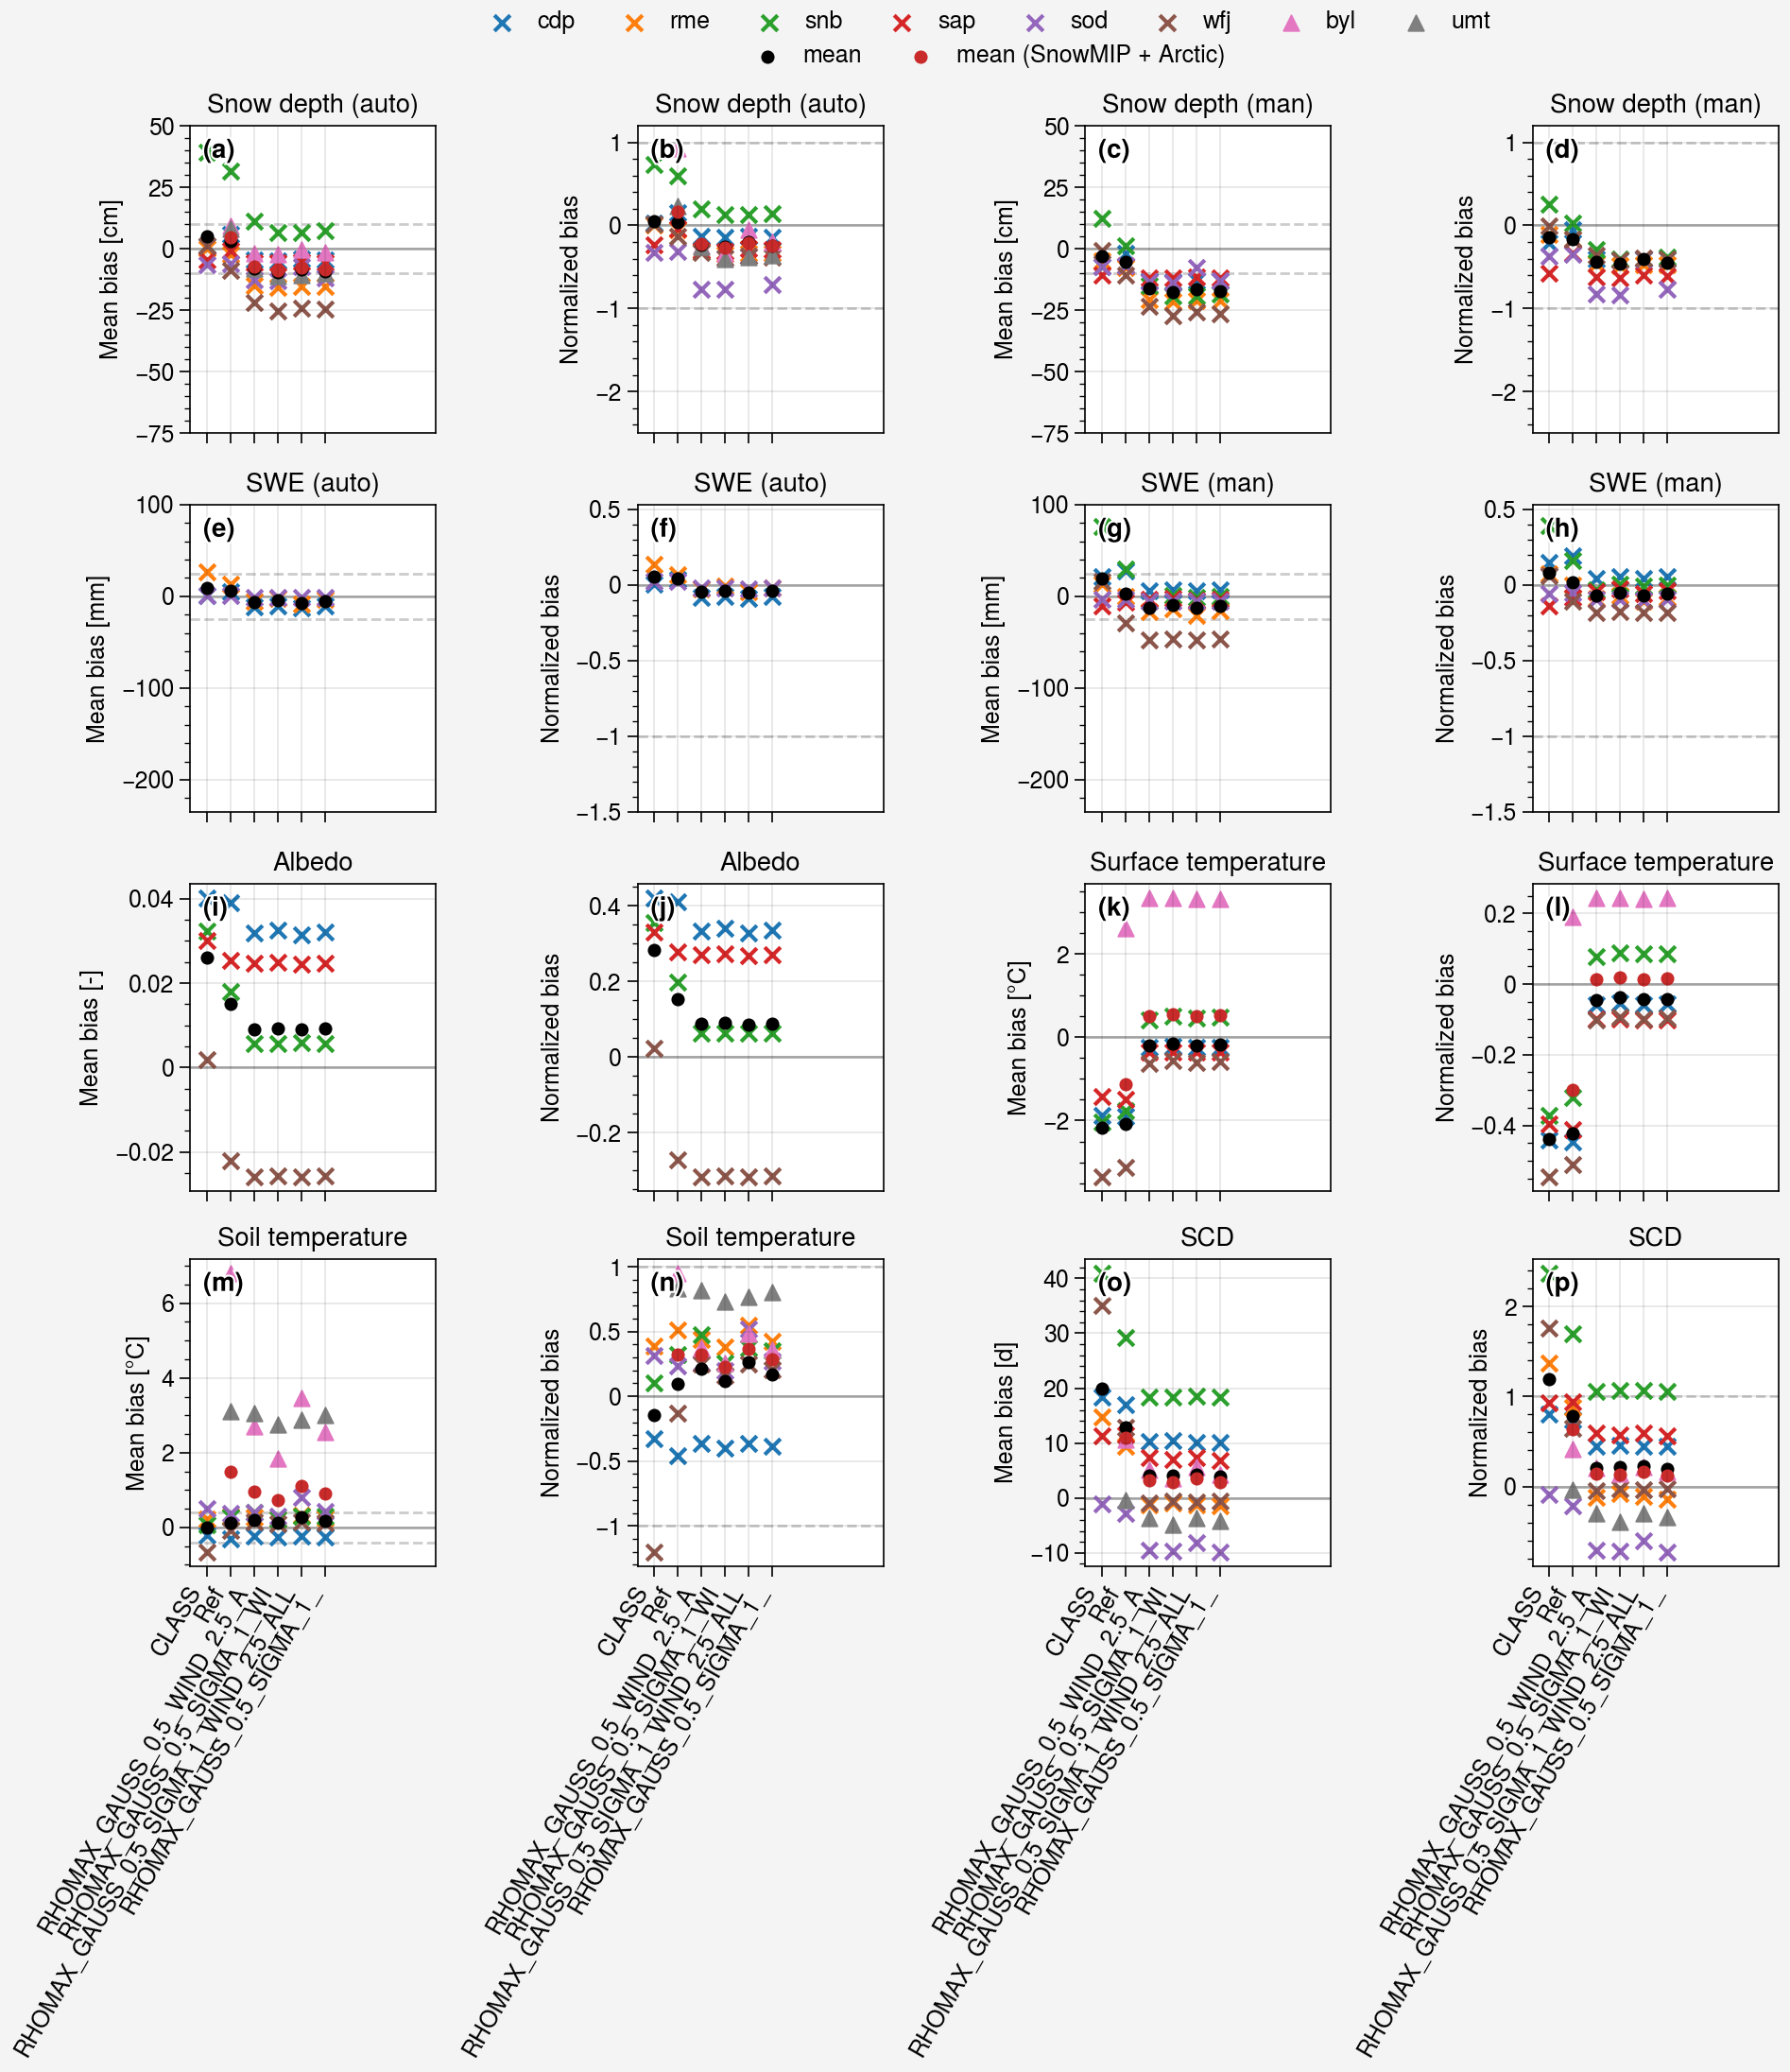

In [36]:
fig, axs = pplt.subplots(ncols=4, nrows=4, sharey=0, refaspect=0.8, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation=60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean'; color_mean='k'; marker_mean_size=80
marker_mean_arc='.'; label_mean_arc='mean (SnowMIP + Arctic)'; color_mean_arc='red9'; marker_mean_arc_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-75, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].mb[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].mb[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-75, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nmb[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[1].format(title='Snow depth (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-2.5, 1.2))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-2.5, 1.2))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].mb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 0.53))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 0.53))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[8].scatter(df_gather_Arctic.loc[('albs')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='Mean bias [-]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('albs')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('albs')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[9].scatter(df_gather_Arctic.loc[('albs')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Albedo', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('ts')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('ts')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('ts')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Surface temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('ts')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('ts')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('ts')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='Surface temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[12].scatter(df_metrics_list[i].loc[('tsl')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[12].scatter(df_gather.loc[('tsl')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[12].scatter(df_gather_Arctic.loc[('tsl')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[12].format(title='Soil temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[13].scatter(df_metrics_list[i].loc[('tsl')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[13].scatter(df_gather.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[13].scatter(df_gather_Arctic.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[13].format(title='Soil temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[14].scatter(df_metrics_list[i].loc[('SCD')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[14].scatter(df_gather.loc[('SCD')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[14].scatter(df_gather_Arctic.loc[('SCD')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[14].format(title='SCD', ylabel='Mean bias [d]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[15].scatter(df_metrics_list[i].loc[('SCD')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[15].scatter(df_gather.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[15].scatter(df_gather_Arctic.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[15].format(title='SCD', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

x_min = -0.7
x_max = 9.7
for ax in axs:
    ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    ax.hlines(0, x_min, x_max, color='k', lw=1, alpha=0.3, zorder=0, ls='-')

# Obs uncertainties (base on Lejeune et al. (2019) at cdp)
axs[0].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[4].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[12].hlines([-0.4, 0.4], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

for i, ax in enumerate(axs):
    if (i % 2) != 0:
        ax.hlines([-1, 1], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')
# fig.save('img/tn1_mb.jpg')

In [37]:
# for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
for var in ['SCD']:
    print('### SnowMIP ###')
    print('MB')
    print('df_gather.loc[('+var+')].mb[1:]')
    print(df_gather.loc[(var)].mb[1:].apply(np.nanmean))
    
    print('\ndf_gather.loc[('+var+')].nmb[1:]')
    print(df_gather.loc[(var)].nmb[1:].apply(np.nanmean))

    print('\nRMSE')
    print('df_gather.loc[('+var+')]rmse[1:]')
    print(df_gather.loc[(var)].rmse[1:].apply(np.nanmean))
    
    print('\ndf_gather.loc[('+var+')].nrmse[1:]')
    print(df_gather.loc[(var)].nrmse[1:].apply(np.nanmean))
    
    
    print('\n### SnowMIP + Arctic ###')
    print('MB')
    print('df_gather_Arctic.loc[('+var+')].mb[1:]')
    print(df_gather_Arctic.loc[(var)].mb[1:].apply(np.nanmean))
    
    print('\ndf_gather_Arctic.loc[('+var+')].nmb[1:]')
    print(df_gather_Arctic.loc[(var)].nmb[1:].apply(np.nanmean))

    print('\nRMSE')
    print('df_gather_Arctic.loc[('+var+')]rmse[1:]')
    print(df_gather_Arctic.loc[(var)].rmse[1:].apply(np.nanmean))
    
    print('\ndf_gather_Arctic.loc[('+var+')].nrmse[1:]')
    print(df_gather_Arctic.loc[(var)].nrmse[1:].apply(np.nanmean))



### SnowMIP ###
MB
df_gather.loc[(SCD)].mb[1:]
CLASS                                              19.877661
Ref_30min_ext                                      12.891783
RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT               4.016036
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL               4.120495
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5     4.312628
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                 3.893908
Name: mb, dtype: float64

df_gather.loc[(SCD)].nmb[1:]
CLASS                                              1.191754
Ref_30min_ext                                      0.783178
RHOMAX_GAUSS_0.5_WIND_2.5_ALL_CORRECT              0.205785
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL              0.211761
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_2.5_ALL_LIMIT_2.5    0.227244
RHOMAX_GAUSS_0.5_SIGMA_1_WIND_3_ALL                0.194154
Name: nmb, dtype: float64

RMSE
df_gather.loc[(SCD)]rmse[1:]
CLASS                                              24.688026
Ref_30min_ext                                     

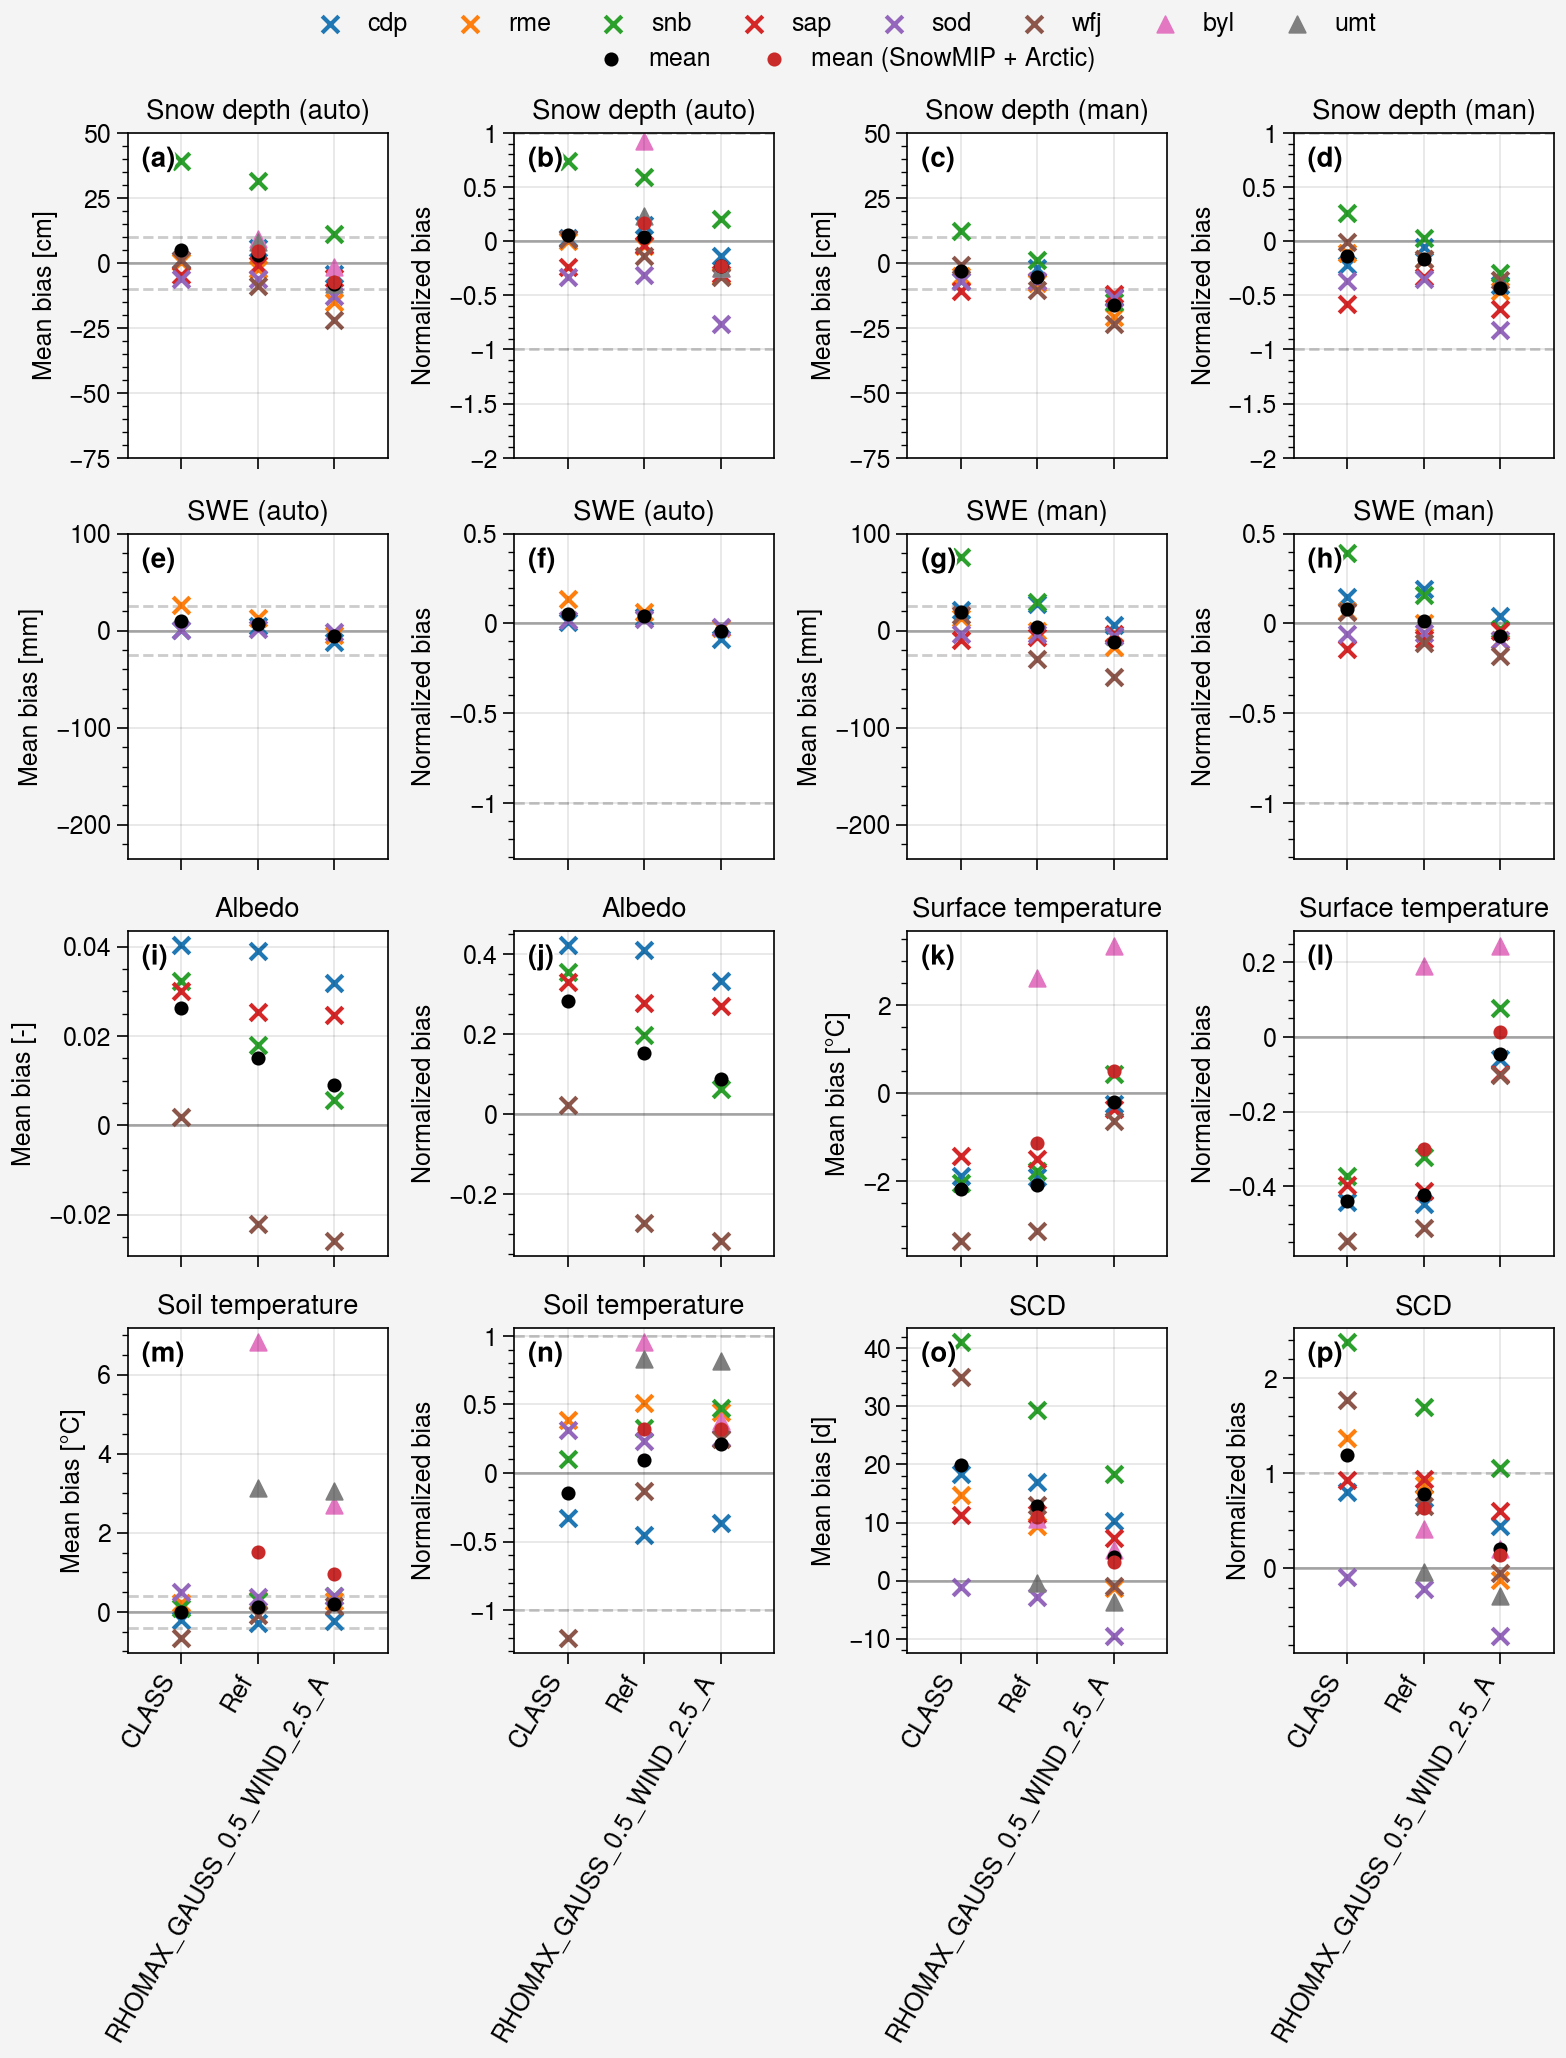

In [38]:
fig, axs = pplt.subplots(ncols=4, nrows=4, sharey=0, refaspect=0.8, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation=60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean'; color_mean='k'; marker_mean_size=80
marker_mean_arc='.'; label_mean_arc='mean (SnowMIP + Arctic)'; color_mean_arc='red9'; marker_mean_arc_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-75, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].mb[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].mb[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-75, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nmb[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[1].format(title='Snow depth (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-2, 1))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-2, 1))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].mb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.31, 0.5))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.31, 0.5))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[8].scatter(df_gather_Arctic.loc[('albs')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='Mean bias [-]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('albs')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('albs')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[9].scatter(df_gather_Arctic.loc[('albs')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Albedo', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('ts')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('ts')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('ts')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Surface temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('ts')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('ts')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('ts')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='Surface temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[12].scatter(df_metrics_list[i].loc[('tsl')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[12].scatter(df_gather.loc[('tsl')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[12].scatter(df_gather_Arctic.loc[('tsl')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[12].format(title='Soil temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[13].scatter(df_metrics_list[i].loc[('tsl')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[13].scatter(df_gather.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[13].scatter(df_gather_Arctic.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[13].format(title='Soil temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[14].scatter(df_metrics_list[i].loc[('SCD')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[14].scatter(df_gather.loc[('SCD')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[14].scatter(df_gather_Arctic.loc[('SCD')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[14].format(title='SCD', ylabel='Mean bias [d]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[15].scatter(df_metrics_list[i].loc[('SCD')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[15].scatter(df_gather.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[15].scatter(df_gather_Arctic.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[15].format(title='SCD', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

x_min = -0.7
x_max = 2.7
for ax in axs:
    ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    ax.hlines(0, x_min, x_max, color='k', lw=1, alpha=0.3, zorder=0, ls='-')

# Obs uncertainties (base on Lejeune et al. (2019) at cdp)
axs[0].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[4].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[12].hlines([-0.4, 0.4], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

for i, ax in enumerate(axs):
    if (i % 2) != 0:
        ax.hlines([-1, 1], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')
# fig.save('img/tn1_mb.jpg')